<a href="https://colab.research.google.com/github/khwwang/coding-training/blob/master/230630_%EC%9D%98%EC%82%AC%EA%B2%B0%EC%A0%95%EB%82%98%EB%AC%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

의사결정나무
노드를 만들어서 분리 시키는 것
그리고 불순도를 측정하는 방법


* cart알고리즘: gini불순도 측정(불순도=impurity)
* gini는 불순도와 엔트로피를 계산
information gain
* 어떤 알고리즘이든 돌리는 방식과 규제하는 파라미터를 이해하면 좋다
* 의사결정나무의 규제는 max_depth, min_sample_split등이 있습니다.
* 변수 중요도

In [130]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [131]:
penguins = pd.read_csv('penguins.csv')

In [132]:
df = penguins.copy()
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [133]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [135]:
df.shape

(344, 7)

In [136]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [137]:
df['species'].value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

In [138]:
df['island'].value_counts()

Biscoe       168
Dream        124
Torgersen     52
Name: island, dtype: int64

In [139]:
df['sex'] = df['sex'].replace('.', np.nan)
df['sex']

0        MALE
1      FEMALE
2      FEMALE
3         NaN
4      FEMALE
        ...  
339       NaN
340    FEMALE
341      MALE
342    FEMALE
343      MALE
Name: sex, Length: 344, dtype: object

In [140]:
df1 = df.copy()

In [141]:
df.columns

Index(['species', 'island', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

In [142]:
cols = ['culmen_length_mm', 'culmen_depth_mm','flipper_length_mm', 'body_mass_g']

In [143]:
for col in cols:
  df1[col].fillna(df[col].mean(), inplace=True)
df1.isna().sum()

species               0
island                0
culmen_length_mm      0
culmen_depth_mm       0
flipper_length_mm     0
body_mass_g           0
sex                  11
dtype: int64

##### sklearn simple imputation으로 결측치 처리하기

In [144]:
from sklearn.impute import SimpleImputer

df2 = df.copy()
si = SimpleImputer(missing_values=np.nan, strategy='mean')
si.fit(df2[cols])
df2[cols] = si.transform(df2[cols])
df2.isna().sum()

species               0
island                0
culmen_length_mm      0
culmen_depth_mm       0
flipper_length_mm     0
body_mass_g           0
sex                  11
dtype: int64

In [145]:
df3 = df.copy()
df3 = df3.dropna()
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            333 non-null    object 
 1   island             333 non-null    object 
 2   culmen_length_mm   333 non-null    float64
 3   culmen_depth_mm    333 non-null    float64
 4   flipper_length_mm  333 non-null    float64
 5   body_mass_g        333 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.8+ KB


In [146]:
df2 = df2.dropna()
y = df2.iloc[:,0]
X = df2.iloc[:,1:]

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
cat_cols = ['island', 'sex']
num_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm','body_mass_g']

one_hot endcoding
범주형 변수중에 순서가 없는 nominal

train데이터 전처리

In [149]:
from sklearn.preprocessing import OneHotEncoder

oh = OneHotEncoder(sparse_output=False)
X_train_cat = oh.fit_transform(X_train[['island', 'sex']])

In [150]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_num = ss.fit_transform(X_train[num_cols])
X_train_num

array([[-0.59372706, -1.75093934,  0.9359428 ,  0.53973681],
       [-1.26104283,  0.32310698, -0.719956  , -1.07236416],
       [ 1.09309891, -0.63803644,  1.65589881,  1.40779118],
       ...,
       [-0.81616565,  0.27252048, -0.5759648 , -1.25837581],
       [ 0.2589542 , -1.0933149 ,  1.36791641,  0.97376399],
       [-1.11275044, -0.08158499, -1.43991201, -1.28937775]])

In [151]:
X_train_con = np.concatenate((X_train_cat, X_train_num), axis=1)

In [152]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

모델만들기

In [153]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train_con, y_train)

DecisionTreeClassifier()

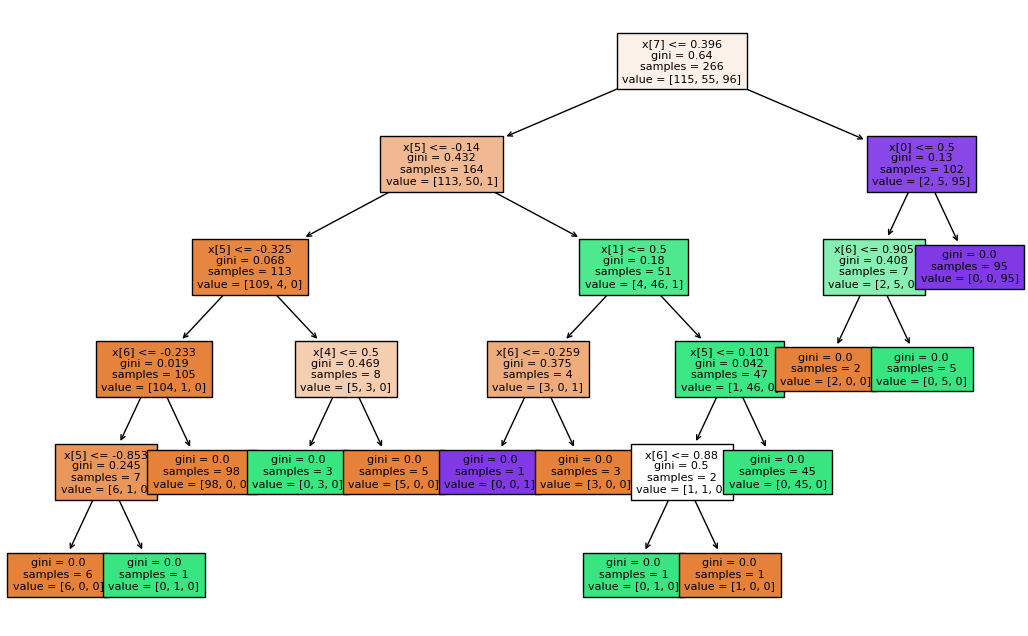

In [154]:
from sklearn.tree import plot_tree
plt.figure(figsize=(13,8))
plot_tree(clf,filled=True, fontsize=8)
plt.show()

test데이터 onehotencoding, standardscaler,LabelEncoder

In [155]:
X_test_cat = oh.fit_transform(X_test[['island', 'sex']])

In [156]:
X_test_num = ss.fit_transform(X_test[num_cols])

In [157]:
X_test_con = np.concatenate((X_test_cat, X_test_num), axis=1)

In [158]:
y_test = le.transform(y_test)

예측및 정확도 측정

In [159]:
y_pred = clf.predict(X_test_con)
acc = accuracy_score
re = recall_score
pr = precision_score
f1 = f1_score

print('accuracy_score : ', acc(y_test, y_pred))
print('recall_score : ', re(y_test, y_pred, average='macro'))
print('precision_score : ', pr(y_test, y_pred, average='macro'))
print('f1_score : ', f1(y_test, y_pred, average='macro'))

accuracy_score :  0.9850746268656716
recall_score :  0.989247311827957
precision_score :  0.9761904761904763
f1_score :  0.9821898401133374


파라미터 튜닝

In [160]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3,4,5],
    'max_leaf_nodes':[5,6,7,8]
}

clf = DecisionTreeClassifier()
grid = GridSearchCV(clf, param_grid=params, cv = 5, n_jobs=-1)
grid.fit(X_train_con, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'max_leaf_nodes': [5, 6, 7, 8]})

In [161]:
grid.best_params_

{'max_depth': 5, 'max_leaf_nodes': 8}

In [162]:
grid.best_score_

0.9699510831586304

In [163]:
grid.best_estimator_.score(X_test_con, y_test)

1.0

In [164]:
clf = DecisionTreeClassifier(max_depth = 5, max_leaf_nodes= 8)
clf.fit(X_train_con, y_train)

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=8)

In [165]:
import pickle # binary로 저장
with open('DT_penguins','wb') as file:
  pickle.dump(clf,file)

In [166]:
with open('DT_penguins','rb') as file:
  my_clf = pickle.load(file)

In [167]:
my_clf.score(X_test_con, y_test)

1.0

In [169]:
with open('onehot_penguins','wb') as file:
  pickle.dump(oh,file)
with open('standard_penguins','wb') as file:
  pickle.dump(ss,file)
with open('label_penguins','wb') as file:
  pickle.dump(le,file)

In [193]:
with open('onehot_penguins','rb') as file:
  my_oh = pickle.load(file)
with open('standard_penguins','rb') as file:
  my_ss = pickle.load(file)
with open('label_penguins','rb') as file:
  my_le = pickle.load(file)

In [179]:
df.columns

Index(['species', 'island', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

In [192]:
data = ['Torgersen', 38.9, 17.8, 181, 3625, 'FEMALE']
data = pd.DataFrame(data).T
data = data.rename(columns={0:'island', 1:'culmen_length_mm', 2:'culmen_depth_mm', 3:'flipper_length_mm', 4:'body_mass_g', 5:'sex'})
data

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,38.9,17.8,181,3625,FEMALE


In [188]:
df['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [191]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [195]:
my_oh.transform(data[['island','sex']])

array([[0., 0., 1., 1., 0.]])

In [ ]:
ss.transform(X_test[num_cols])